## 1. import library

In [3]:
import pandas as pd
import numpy as np
import re
from tqdm import tqdm

from gensim.models.fasttext import FastText
 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

## 2. Preprocessed Data

In [4]:
word_tokens = [['quick', 'mtg'],
 ['cucumber', 'strawberry', 'refresher'],
 ['nice', 'good', 'service', 'good', 'food'],
 ['small', 'place', 'staff', 'friendly'],
 ['yay', 'sandwich', 'nostaffu', 'total', 'bargain', 'sandwich', 'awesome']]

## 3. Build FastText Model

In [11]:
from time import time

embedding_size = 100
window_size = 5
min_word = 1
down_sampling = 1e-2
 
t0 = time()
fast_Text_model = FastText(word_tokens,
                      vector_size=embedding_size,
                      window=window_size,
                      min_count=min_word,
                      sample=down_sampling,
                      workers = 4,
                      sg=1,
                      epochs=100);

print(f"\nTraining time: {round(time()-t0, 3)}s")


Training time: 1.076s


In [12]:
# Save fastText gensim model
fast_Text_model.save("model/ft_model")

## 4. Explore Model

In [13]:
from gensim.models import Word2Vec
# Load saved gensim fastText model
fast_Text_model = Word2Vec.load("model/ft_model")

In [14]:
# Check word embedding for a perticular word 
fast_Text_model.wv['theservice of staff is good super']

array([-1.49177131e-03,  8.83172266e-04,  3.14428646e-04, -5.36011175e-05,
        4.02795325e-04,  8.16551183e-05,  4.76690257e-05,  3.85001535e-04,
       -3.12160671e-04, -2.43557879e-04, -6.76430762e-04, -9.02150350e-04,
        1.73195549e-05,  1.50748272e-03,  4.71884618e-04, -8.24975665e-04,
        5.93960649e-05,  4.13560367e-04, -2.81986926e-04, -1.38229094e-04,
        3.33344593e-04, -9.42757761e-04,  9.50736634e-04,  1.07987039e-03,
        1.40714960e-03, -2.75058643e-04,  6.16602367e-04, -8.47805059e-04,
        1.31281791e-03,  2.06476121e-04,  4.10324283e-05, -2.16077111e-04,
       -8.78163963e-04, -7.05074577e-04, -3.46704794e-04,  7.19321775e-04,
        2.35355892e-05,  1.48475912e-04,  8.60856264e-04,  3.08710005e-04,
       -1.14230505e-04, -1.13732088e-03,  1.27035833e-03, -2.91913078e-04,
        6.91096415e-04, -5.89266012e-04, -2.26766759e-04, -7.33948953e-04,
        1.63060875e-04, -1.48878258e-03,  5.30056830e-04, -8.18783068e-04,
       -3.43941530e-04, -

In [15]:
# Dimention must be 100
fast_Text_model.wv['staff'].shape

(100,)

In [16]:
# Check top 10 similar word for a given word by gensim fastText
fast_Text_model.wv.most_similar('staff', topn=10)

[('nostaffu', 0.880402684211731),
 ('sandwich', 0.8160879611968994),
 ('place', 0.8003676533699036),
 ('good', 0.7828870415687561),
 ('strawberry', 0.7416397333145142),
 ('total', 0.7295132875442505),
 ('food', 0.7260056138038635),
 ('bargain', 0.7185301780700684),
 ('small', 0.6974852681159973),
 ('refresher', 0.676905632019043)]

In [17]:
# Check top 10 similarity score between two word
fast_Text_model.wv.similarity('staff', 'nostaffu')

0.8804027

## 5. Visualisasi

In [21]:
# tsne plot for below word
# for_word = 'food'
def tsne_plot(for_word, w2v_model):
    # trained fastText model dimention
    dim_size = w2v_model.wv.vectors.shape[1]
 
    arrays = np.empty((0, dim_size), dtype='f')
    word_labels = [for_word]
    color_list  = ['red']
 
    # adds the vector of the query word
    arrays = np.append(arrays, w2v_model.wv.__getitem__([for_word]), axis=0)
 
    # gets list of most similar words
    sim_words = w2v_model.wv.most_similar(for_word, topn=10)
 
    # adds the vector for each of the closest words to the array
    for wrd_score in sim_words:
        wrd_vector = w2v_model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
 
    #---------------------- Apply PCA and tsne to reduce dimention --------------
 
    # fit 2d PCA model to the similar word vectors
    model_pca = PCA(n_components = 10).fit_transform(arrays)
 
    # Finds 2d coordinates t-SNE
    np.set_printoptions(suppress=True)
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(model_pca)
 
    # Sets everything up to plot
    df_plot = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words_name': word_labels,
                       'words_color': color_list})
 
    #------------------------- tsne plot Python -----------------------------------
 
    # plot dots with color and position
    plot_dot = sns.regplot(data=df_plot,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df_plot['words_color']
                                 }
                    )
 
    # Adds annotations with color one by one with a loop
    for line in range(0, df_plot.shape[0]):
         plot_dot.text(df_plot["x"][line],
                 df_plot['y'][line],
                 '  ' + df_plot["words_name"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df_plot['words_color'][line],
                 weight='normal'
                ).set_size(15)
 
 
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
 
    plt.title('t-SNE visualization for word "{}'.format(for_word.title()) +'"')

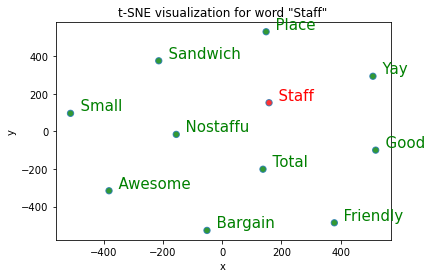

In [23]:
# tsne plot for top 10 similar word to 'chicken'
tsne_plot(for_word='staff', w2v_model=fast_Text_model)